## Setup

In [72]:
# Loading packages and their components
import pandas as pd
import numpy as np
import pickle

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, explained_variance_score, mean_absolute_error

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.api import acf, pacf, graphics
from statsmodels.graphics.api import qqplot
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.preprocessing import PolynomialFeatures

In [73]:
pd.options.display.max_rows = 100 # For debugging, can be removed later

In [74]:
# Matplotlib configuration
plt.rcParams['figure.figsize'] = [15, 7]

## Helper functions

In [75]:
def model_classification(actual, predicted):
    '''
    Prints out RSME, MAE and explained variance score
    '''
    print('-'*20)
    print(f'RMSE: {round(np.sqrt(mean_squared_error(actual, predicted)),2)}')
    print('-'*20)
    print(f'MAE: {round(mean_absolute_error(actual, predicted),2)}')
    print(f'Explained variance: {round(explained_variance_score(actual, predicted),3)}')
    print('-'*20)

In [76]:
def rem_col(df, col):
    '''
    Removes columns from a dataframe that contain a string.
    '''
    return df.loc[:,~df.columns.str.contains(col)]

In [77]:
def rem_cols(df, cols):
    '''
    Removes multiple columns from a dataframe that contain a string in a given list.
    '''
    for colname in cols:
        df = df.loc[:,~df.columns.str.contains(colname)]
    return df

In [78]:
def std_scaler(df):
    '''
    Sklearn StandardScaler applied to a pandas dataframe for the use with method chaining.
    '''
    colnames = df.columns.to_list()
    scaler = StandardScaler()
    df = scaler.fit_transform(df)
    df = pd.DataFrame(df)
    df.columns = colnames
    return df

## Loading the data

In [79]:
data_subsets = pickle.load(open('cleaned_data.pickle', 'rb'))

In [80]:
# Splitting the data into their parts
sj_features_train, \
sj_features_test, \
sj_labels_train, \
iq_features_train, \
iq_features_test, \
iq_labels_train = data_subsets

In [81]:
# join only the total cases column!!!
def custom_join_xy(dfx, dfy):
    df = (
        dfx.join(dfy, rsuffix='_drop')
        .pipe(rem_col, '_drop')
        .pipe(pd.DataFrame.drop, ['city',
                                  'year',
                                  'weekofyear'
                                 ], axis=1)
    )
    return df

In [82]:
sj_train = custom_join_xy(sj_features_train, sj_labels_train)
iq_train = custom_join_xy(iq_features_train, iq_labels_train)

In [83]:
def iq_from_2002(df):
    return df['2002-01-01':]

In [84]:
iq_train = iq_from_2002(iq_train)

In [85]:
def log_cases(df):
    df = df.assign(logged_cases = lambda df: np.log(df['total_cases']+1))
    return df

In [86]:
sj_train = log_cases(sj_train)
iq_train = log_cases(iq_train)

In [87]:
def train_test_timesplit(df, ratio=0.75):
    time_index = list(df.index)
    df = df.reset_index()
    df_train = df.loc[:int(len(time_index)*ratio),:]
    df_train.index = time_index[:int(len(time_index)*ratio)+1]
    df_test = df.loc[int(len(time_index)*ratio)+1:,:]
    df_test.index = time_index[int(len(time_index)*ratio)+1:]
    return df_train, df_test

### Adding lags and etc.

In [17]:
def add_lags_by_list(df, lag_list):
    lagged_dfs = []
    for lag in lag_list:
        lagged_cols = []
        for col in df.columns:
            lagged_cols.append(df[col].shift(lag))
        lagged_dfs.append(pd.DataFrame(lagged_cols).T)
#     print(len(lagged_dfs))
    df_lagged = df.join(lagged_dfs[0], rsuffix='_L%i' % (lag_list[0]))
    for j in range(len(lagged_dfs)-1):
        lag_info = lag_list[j+1]
        df_lagged = df_lagged.join(lagged_dfs[j+1], rsuffix='_L%i' % (lag_info))
    return df_lagged

In [18]:
def add_n_lags(df, nlags):
    lagged_dfs = []
    for i in range(1, nlags+1):
        lagged_cols = []
        for col in df.columns:
            lagged_cols.append(df[col].shift(i))
        lagged_dfs.append(pd.DataFrame(lagged_cols).T)
#     print(len(lagged_dfs))
    df_lagged = df.join(lagged_dfs[0], rsuffix='_L1')
    for j in range(len(lagged_dfs)-1):
        laginfo = j+2
        df_lagged = df_lagged.join(lagged_dfs[j+1], rsuffix='_L%i' % (laginfo))
    return df_lagged

In [20]:
interactions = PolynomialFeatures(interaction_only=True)
sj_train_inter = interactions.fit_transform(sj_train.dropna())
sj_train_inter = pd.DataFrame(sj_train_inter, index=sj_train.dropna().index)
sj_train_inter = sj_train.join(sj_train_inter)

In [26]:
sj_train_inter_lags = add_n_lags(sj_train_inter, 3)

In [27]:
def rem_col(df, col):
    '''
    Removes columns from a dataframe that contain a string.
    '''
    return df.loc[:,~df.columns.str.contains(col)]

In [28]:
sj_train_inter_lags = rem_col(sj_train_inter_lags, 'cases')

In [29]:
sj_train_inter_lags

,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,...,244_L3,245_L3,246_L3,247_L3,248_L3,249_L3,250_L3,251_L3,252_L3,253_L3
week_start_date,,,,,,,,,,,,,,,,,,,,,
1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,295.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,300.9,296.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,300.5,297.3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,301.4,297.0,...,588.00,470.40,117.6,47.317475,320.00,80.0,32.188758,64.0,25.751007,6.437752
1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,301.9,297.5,...,703.74,272.62,158.5,56.798775,190.92,111.0,39.777060,43.0,15.409131,8.958797
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008-03-25,0.077850,-0.039900,0.310471,0.296243,27.19,296.958571,296.957143,292.095714,299.7,294.4,...,620.34,382.20,29.4,20.378527,274.30,21.1,14.625406,13.0,9.010913,0.693147
2008-04-01,-0.038000,-0.016833,0.119371,0.066386,3.82,298.081429,298.228571,293.235714,299.8,296.5,...,641.58,127.16,57.8,31.749895,97.68,44.4,24.389193,8.8,4.833894,2.197225
2008-04-08,-0.155200,-0.052750,0.137757,0.141214,16.96,297.460000,297.564286,292.732857,299.4,295.8,...,618.00,15.00,90.0,41.588831,10.30,61.8,28.557664,1.5,0.693147,4.158883


In [30]:
sj_train_inter_lags = sj_train_inter_lags.join(sj_train.total_cases)

In [31]:
corr_with_cases = (
    sj_train_inter_lags
    .corr()['total_cases']
    .sort_values()
    .loc[lambda x: abs(x)>0.1]
)
# corr_with_cases[~ corr_with_cases.index.str.contains('cases')]
corr_with_cases

233            0.101058
191_L1         0.101480
91_L1          0.102203
83_L1          0.102203
191_L3         0.104701
                 ...   
147            0.999994
132            0.999994
186            0.999994
21             1.000000
total_cases    1.000000
Name: total_cases, Length: 599, dtype: float64

In [32]:
corr_with_cases.head()

233       0.101058
191_L1    0.101480
91_L1     0.102203
83_L1     0.102203
191_L3    0.104701
Name: total_cases, dtype: float64

In [29]:
# sj_train = add_n_lags(sj_train, 24)

In [45]:
sj_train = sj_train_inter_lags

In [46]:
sj_train_train, sj_train_test = train_test_timesplit(sj_train)
iq_train_train, iq_train_test = train_test_timesplit(iq_train)

In [42]:
# sj_train_train = sj_train_train.asfreq('W')
# sj_train_test = sj_train_test.asfreq('W')

# iq_train_train = iq_train_train.asfreq('W')
# iq_train_test = iq_train_test.asfreq('W')

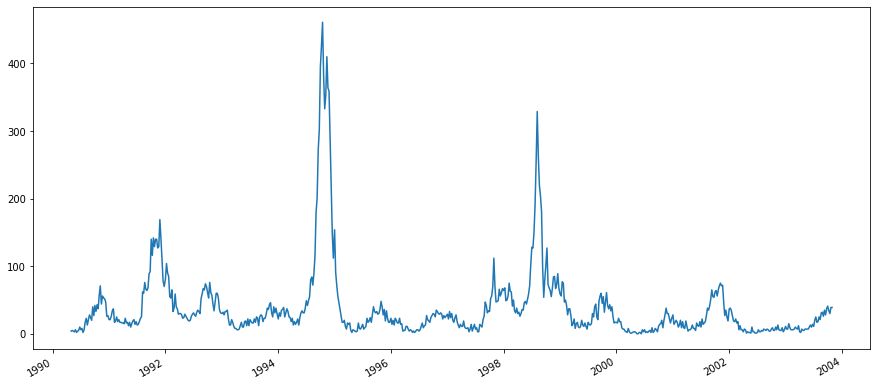

In [47]:
sj_train_train.total_cases.plot();

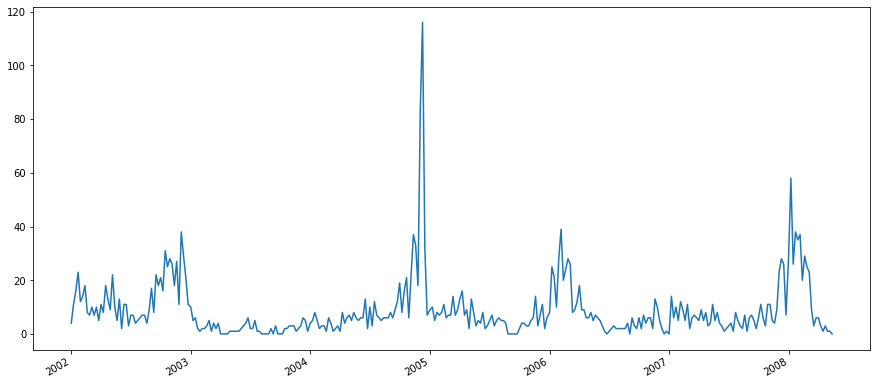

In [48]:
iq_train_train.total_cases.plot();

### First order differencing

In [49]:
sj_train_train_diff = sj_train_train - sj_train_train.shift(1)
sj_train_train_diff = sj_train_train_diff.dropna()

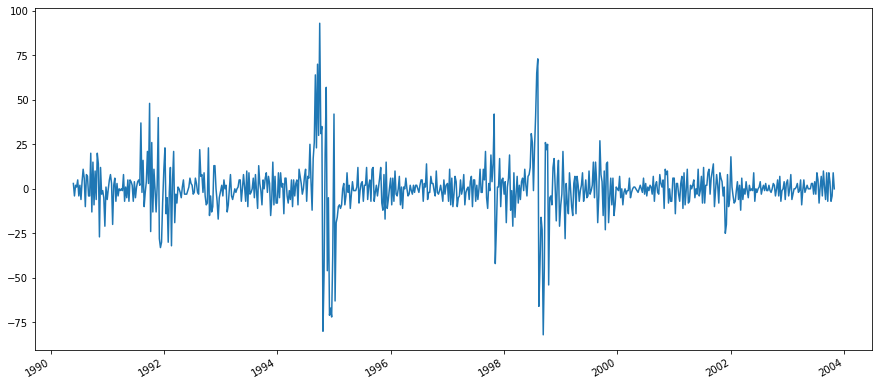

In [50]:
sj_train_train_diff.total_cases.plot();

### ACF

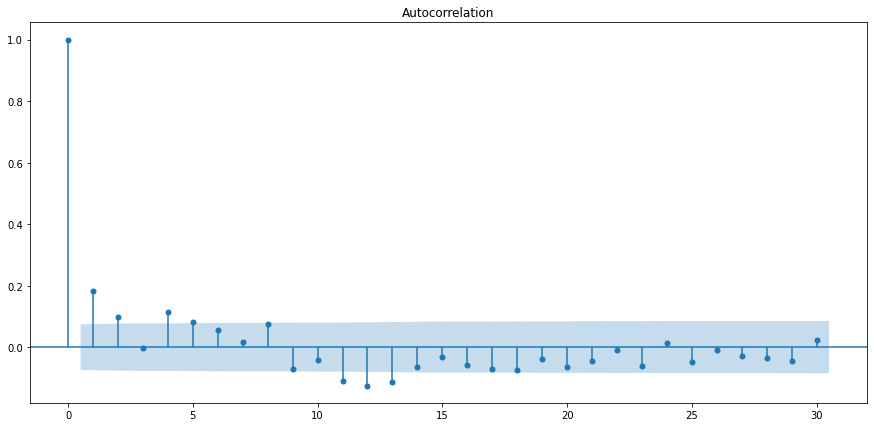

In [51]:
# Check the PACF for the optimal number of lags
plot_acf(sj_train_train_diff.total_cases, lags=30);

### PACF

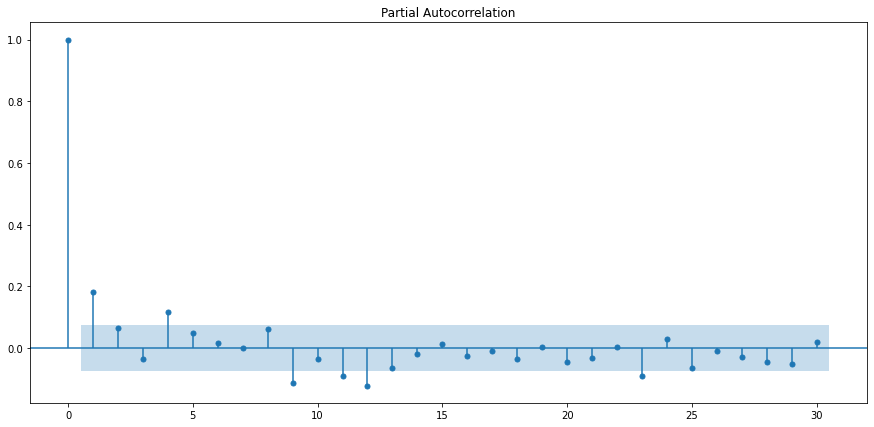

In [52]:
# Check the PACF for the optimal number of lags
plot_pacf(sj_train_train_diff.total_cases, lags=30);

## San Juan

In [88]:
from prophet import Prophet

In [89]:
from __future__ import absolute_import, division, print_function

import logging
from collections import OrderedDict, defaultdict
from copy import deepcopy
from datetime import timedelta, datetime

import numpy as np
import pandas as pd
from scipy.stats import nbinom

from prophet.make_holidays import get_holiday_names, make_holidays_df
from prophet.models import StanBackendEnum
from prophet.plot import (plot, plot_components)

logger = logging.getLogger('prophet')
logger.setLevel(logging.INFO)


class Prophet(object):
    """Prophet forecaster.

    Parameters
    ----------
    growth: String 'linear' or 'logistic' to specify a linear or logistic
        trend.
    changepoints: List of dates at which to include potential changepoints. If
        not specified, potential changepoints are selected automatically.
    n_changepoints: Number of potential changepoints to include. Not used
        if input `changepoints` is supplied. If `changepoints` is not supplied,
        then n_changepoints potential changepoints are selected uniformly from
        the first `changepoint_range` proportion of the history.
    changepoint_range: Proportion of history in which trend changepoints will
        be estimated. Defaults to 0.8 for the first 80%. Not used if
        `changepoints` is specified.
    yearly_seasonality: Fit yearly seasonality.
        Can be 'auto', True, False, or a number of Fourier terms to generate.
    weekly_seasonality: Fit weekly seasonality.
        Can be 'auto', True, False, or a number of Fourier terms to generate.
    daily_seasonality: Fit daily seasonality.
        Can be 'auto', True, False, or a number of Fourier terms to generate.
    holidays: pd.DataFrame with columns holiday (string) and ds (date type)
        and optionally columns lower_window and upper_window which specify a
        range of days around the date to be included as holidays.
        lower_window=-2 will include 2 days prior to the date as holidays. Also
        optionally can have a column prior_scale specifying the prior scale for
        that holiday.
    seasonality_mode: 'additive' (default) or 'multiplicative'.
    seasonality_prior_scale: Parameter modulating the strength of the
        seasonality model. Larger values allow the model to fit larger seasonal
        fluctuations, smaller values dampen the seasonality. Can be specified
        for individual seasonalities using add_seasonality.
    holidays_prior_scale: Parameter modulating the strength of the holiday
        components model, unless overridden in the holidays input.
    changepoint_prior_scale: Parameter modulating the flexibility of the
        automatic changepoint selection. Large values will allow many
        changepoints, small values will allow few changepoints.
    mcmc_samples: Integer, if greater than 0, will do full Bayesian inference
        with the specified number of MCMC samples. If 0, will do MAP
        estimation.
    interval_width: Float, width of the uncertainty intervals provided
        for the forecast. If mcmc_samples=0, this will be only the uncertainty
        in the trend using the MAP estimate of the extrapolated generative
        model. If mcmc.samples>0, this will be integrated over all model
        parameters, which will include uncertainty in seasonality.
    uncertainty_samples: Number of simulated draws used to estimate
        uncertainty intervals. Settings this value to 0 or False will disable
        uncertainty estimation and speed up the calculation.
    likelihood: str "Gaussian", "NegBinomial", or "auto". Defaults "auto".
    stan_backend: str as defined in StanBackendEnum default: None - will try to
        iterate over all available backends and find the working one
    """

    def __init__(
            self,
            growth='linear',
            changepoints=None,
            n_changepoints=25,
            changepoint_range=0.8,
            yearly_seasonality='auto',
            weekly_seasonality='auto',
            daily_seasonality='auto',
            holidays=None,
            seasonality_mode='additive',
            seasonality_prior_scale=10.0,
            holidays_prior_scale=10.0,
            changepoint_prior_scale=0.05,
            mcmc_samples=0,
            interval_width=0.80,
            uncertainty_samples=1000,
            likelihood='auto',
            stan_backend=None,
    ):
        self.growth = growth

        self.changepoints = changepoints
        if self.changepoints is not None:
            self.changepoints = pd.Series(pd.to_datetime(self.changepoints), name='ds')
            self.n_changepoints = len(self.changepoints)
            self.specified_changepoints = True
        else:
            self.n_changepoints = n_changepoints
            self.specified_changepoints = False

        self.changepoint_range = changepoint_range
        self.yearly_seasonality = yearly_seasonality
        self.weekly_seasonality = weekly_seasonality
        self.daily_seasonality = daily_seasonality
        self.holidays = holidays

        self.seasonality_mode = seasonality_mode
        self.seasonality_prior_scale = float(seasonality_prior_scale)
        self.changepoint_prior_scale = float(changepoint_prior_scale)
        self.holidays_prior_scale = float(holidays_prior_scale)

        self.mcmc_samples = mcmc_samples
        self.interval_width = interval_width
        self.uncertainty_samples = uncertainty_samples
        self.likelihood = likelihood

        # Set during fitting or by other methods
        self.start = None
        self.y_scale = None
        self.logistic_floor = False
        self.t_scale = None
        self.changepoints_t = None
        self.seasonalities = OrderedDict({})
        self.extra_regressors = OrderedDict({})
        self.country_holidays = None
        self.stan_fit = None
        self.params = {}
        self.history = None
        self.history_dates = None
        self.train_component_cols = None
        self.component_modes = None
        self.train_holiday_names = None
        self.fit_kwargs = {}
        self.validate_inputs()
        self._load_stan_backend(stan_backend)

    def _load_stan_backend(self, stan_backend):
        if stan_backend is None:
            for i in StanBackendEnum:
                try:
                    logger.debug("Trying to load backend: %s", i.name)
                    return self._load_stan_backend(i.name)
                except Exception as e:
                    logger.debug("Unable to load backend %s (%s), trying the next one", i.name, e)
        else:
            self.stan_backend = StanBackendEnum.get_backend_class(stan_backend)()

        logger.debug("Loaded stan backend: %s", self.stan_backend.get_type())

    def validate_inputs(self):
        """Validates the inputs to Prophet."""
        if self.growth not in ('linear', 'logistic', 'flat'):
            raise ValueError(
                'Parameter "growth" should be "linear", "logistic" or "flat".')
        if ((self.changepoint_range < 0) or (self.changepoint_range > 1)):
            raise ValueError('Parameter "changepoint_range" must be in [0, 1]')
        if self.holidays is not None:
            if not (
                isinstance(self.holidays, pd.DataFrame)
                and 'ds' in self.holidays  # noqa W503
                and 'holiday' in self.holidays  # noqa W503
            ):
                raise ValueError('holidays must be a DataFrame with "ds" and '
                                 '"holiday" columns.')
            self.holidays['ds'] = pd.to_datetime(self.holidays['ds'])
            if (
                self.holidays['ds'].isnull().any()
                or self.holidays['holiday'].isnull().any()
            ):
                raise ValueError('Found a NaN in holidays dataframe.')
            has_lower = 'lower_window' in self.holidays
            has_upper = 'upper_window' in self.holidays
            if has_lower + has_upper == 1:
                raise ValueError('Holidays must have both lower_window and ' +
                                 'upper_window, or neither')
            if has_lower:
                if self.holidays['lower_window'].max() > 0:
                    raise ValueError('Holiday lower_window should be <= 0')
                if self.holidays['upper_window'].min() < 0:
                    raise ValueError('Holiday upper_window should be >= 0')
            for h in self.holidays['holiday'].unique():
                self.validate_column_name(h, check_holidays=False)
        if self.seasonality_mode not in ['additive', 'multiplicative']:
            raise ValueError(
                'seasonality_mode must be "additive" or "multiplicative"'
            )
        if self.likelihood not in ['Gaussian', 'NegBinomial', 'auto']:
            raise ValueError('Incorrect likelihood specification')
        if self.likelihood == 'NegBinomial' and self.growth == 'linear':
            # In the future we can get rid of the requirement for cap, but we must have a positive trend.
            raise ValueError('Must use logistic trend with NegBinomial likelihood')

    def validate_column_name(self, name, check_holidays=True,
                             check_seasonalities=True, check_regressors=True):
        """Validates the name of a seasonality, holiday, or regressor.

        Parameters
        ----------
        name: string
        check_holidays: bool check if name already used for holiday
        check_seasonalities: bool check if name already used for seasonality
        check_regressors: bool check if name already used for regressor
        """
        if '_delim_' in name:
            raise ValueError('Name cannot contain "_delim_"')
        reserved_names = [
            'trend', 'additive_terms', 'daily', 'weekly', 'yearly',
            'holidays', 'zeros', 'extra_regressors_additive', 'yhat',
            'extra_regressors_multiplicative', 'multiplicative_terms',
        ]
        rn_l = [n + '_lower' for n in reserved_names]
        rn_u = [n + '_upper' for n in reserved_names]
        reserved_names.extend(rn_l)
        reserved_names.extend(rn_u)
        reserved_names.extend([
            'ds', 'y', 'cap', 'floor', 'y_scaled', 'cap_scaled'])
        if name in reserved_names:
            raise ValueError(
                'Name {name!r} is reserved.'.format(name=name)
            )
        if (check_holidays and self.holidays is not None and
                name in self.holidays['holiday'].unique()):
            raise ValueError(
                'Name {name!r} already used for a holiday.'.format(name=name)
            )
        if (check_holidays and self.country_holidays is not None and
                name in get_holiday_names(self.country_holidays)):
            raise ValueError(
                'Name {name!r} is a holiday name in {country_holidays}.'
                .format(name=name, country_holidays=self.country_holidays)
            )
        if check_seasonalities and name in self.seasonalities:
            raise ValueError(
                'Name {name!r} already used for a seasonality.'
                .format(name=name)
            )
        if check_regressors and name in self.extra_regressors:
            raise ValueError(
                'Name {name!r} already used for an added regressor.'
                .format(name=name)
            )

    def setup_dataframe(self, df, initialize_scales=False):
        """Prepare dataframe for fitting or predicting.

        Adds a time index and scales y. Creates auxiliary columns 't', 't_ix',
        'y_scaled', and 'cap_scaled'. These columns are used during both
        fitting and predicting.

        Parameters
        ----------
        df: pd.DataFrame with columns ds, y, and cap if logistic growth. Any
            specified additional regressors must also be present.
        initialize_scales: Boolean set scaling factors in self from df.

        Returns
        -------
        pd.DataFrame prepared for fitting or predicting.
        """
        if 'y' in df:  # 'y' will be in training data
            df['y'] = pd.to_numeric(df['y'])
            if np.isinf(df['y'].values).any():
                raise ValueError('Found infinity in column y.')
        if df['ds'].dtype == np.int64:
            df['ds'] = df['ds'].astype(str)
        df['ds'] = pd.to_datetime(df['ds'])
        if df['ds'].dt.tz is not None:
            raise ValueError(
                'Column ds has timezone specified, which is not supported. '
                'Remove timezone.'
            )
        if df['ds'].isnull().any():
            raise ValueError('Found NaN in column ds.')
        for name in self.extra_regressors:
            if name not in df:
                raise ValueError(
                    'Regressor {name!r} missing from dataframe'
                    .format(name=name)
                )
            df[name] = pd.to_numeric(df[name])
            if df[name].isnull().any():
                raise ValueError(
                    'Found NaN in column {name!r}'.format(name=name)
                )
        for props in self.seasonalities.values():
            condition_name = props['condition_name']
            if condition_name is not None:
                if condition_name not in df:
                    raise ValueError(
                        'Condition {condition_name!r} missing from dataframe'
                        .format(condition_name=condition_name)
                    )
                if not df[condition_name].isin([True, False]).all():
                    raise ValueError(
                        'Found non-boolean in column {condition_name!r}'
                        .format(condition_name=condition_name)
                    )
                df[condition_name] = df[condition_name].astype('bool')

        if df.index.name == 'ds':
            df.index.name = None
        df = df.sort_values('ds')
        df = df.reset_index(drop=True)

        self.initialize_scales(initialize_scales, df)

        if self.logistic_floor:
            if 'floor' not in df:
                raise ValueError('Expected column "floor".')
        else:
            df['floor'] = 0
        if self.growth == 'logistic':
            if 'cap' not in df:
                raise ValueError(
                    'Capacities must be supplied for logistic growth in '
                    'column "cap"'
                )
            if (df['cap'] <= df['floor']).any():
                raise ValueError(
                    'cap must be greater than floor (which defaults to 0).'
                )
            df['cap_scaled'] = (df['cap'] - df['floor']) / self.y_scale

        df['t'] = (df['ds'] - self.start) / self.t_scale
        if 'y' in df:
            df['y_scaled'] = (df['y'] - df['floor']) / self.y_scale

        for name, props in self.extra_regressors.items():
            df[name] = ((df[name] - props['mu']) / props['std'])
        return df

    def initialize_scales(self, initialize_scales, df):
        """Initialize model scales.

        Sets model scaling factors using df.

        Parameters
        ----------
        initialize_scales: Boolean set the scales or not.
        df: pd.DataFrame for setting scales.
        """
        if not initialize_scales:
            return
        if self.growth == 'logistic' and 'floor' in df:
            self.logistic_floor = True
            floor = df['floor']
        else:
            floor = 0.
        self.y_scale = float((df['y'] - floor).abs().max())
        if self.y_scale == 0:
            self.y_scale = 1.0
        self.start = df['ds'].min()
        self.t_scale = df['ds'].max() - self.start
        for name, props in self.extra_regressors.items():
            standardize = props['standardize']
            n_vals = len(df[name].unique())
            if n_vals < 2:
                standardize = False
            if standardize == 'auto':
                if set(df[name].unique()) == {1, 0}:
                    standardize = False #  Don't standardize binary variables.
                else:
                    standardize = True
            if standardize:
                mu = df[name].mean()
                std = df[name].std()
                self.extra_regressors[name]['mu'] = mu
                self.extra_regressors[name]['std'] = std

    def set_changepoints(self):
        """Set changepoints

        Sets m$changepoints to the dates of changepoints. Either:
        1) The changepoints were passed in explicitly.
            A) They are empty.
            B) They are not empty, and need validation.
        2) We are generating a grid of them.
        3) The user prefers no changepoints be used.
        """
        if self.changepoints is not None:
            if len(self.changepoints) == 0:
                pass
            else:
                too_low = min(self.changepoints) < self.history['ds'].min()
                too_high = max(self.changepoints) > self.history['ds'].max()
                if too_low or too_high:
                    raise ValueError(
                        'Changepoints must fall within training data.')
        else:
            # Place potential changepoints evenly through first
            # `changepoint_range` proportion of the history
            hist_size = int(np.floor(self.history.shape[0]
                                     * self.changepoint_range))
            if self.n_changepoints + 1 > hist_size:
                self.n_changepoints = hist_size - 1
                logger.info(
                    'n_changepoints greater than number of observations. '
                    'Using {n_changepoints}.'
                    .format(n_changepoints=self.n_changepoints)
                )
            if self.n_changepoints > 0:
                cp_indexes = (
                    np.linspace(0, hist_size - 1, self.n_changepoints + 1)
                        .round()
                        .astype(int)
                )
                self.changepoints = (
                    self.history.iloc[cp_indexes]['ds'].tail(-1)
                )
            else:
                # set empty changepoints
                self.changepoints = pd.Series(pd.to_datetime([]), name='ds')
        if len(self.changepoints) > 0:
            self.changepoints_t = np.sort(np.array(
                (self.changepoints - self.start) / self.t_scale))
        else:
            self.changepoints_t = np.array([0])  # dummy changepoint

    @staticmethod
    def fourier_series(dates, period, series_order):
        """Provides Fourier series components with the specified frequency
        and order.

        Parameters
        ----------
        dates: pd.Series containing timestamps.
        period: Number of days of the period.
        series_order: Number of components.

        Returns
        -------
        Matrix with seasonality features.
        """
        # convert to days since epoch
        t = np.array(
            (dates - datetime(1970, 1, 1))
                .dt.total_seconds()
                .astype(float)
        ) / (3600 * 24.)
        return np.column_stack([
            fun((2.0 * (i + 1) * np.pi * t / period))
            for i in range(series_order)
            for fun in (np.sin, np.cos)
        ])

    @classmethod
    def make_seasonality_features(cls, dates, period, series_order, prefix):
        """Data frame with seasonality features.

        Parameters
        ----------
        cls: Prophet class.
        dates: pd.Series containing timestamps.
        period: Number of days of the period.
        series_order: Number of components.
        prefix: Column name prefix.

        Returns
        -------
        pd.DataFrame with seasonality features.
        """
        features = cls.fourier_series(dates, period, series_order)
        columns = [
            '{}_delim_{}'.format(prefix, i + 1)
            for i in range(features.shape[1])
        ]
        return pd.DataFrame(features, columns=columns)

    def construct_holiday_dataframe(self, dates):
        """Construct a dataframe of holiday dates.

        Will combine self.holidays with the built-in country holidays
        corresponding to input dates, if self.country_holidays is set.

        Parameters
        ----------
        dates: pd.Series containing timestamps used for computing seasonality.

        Returns
        -------
        dataframe of holiday dates, in holiday dataframe format used in
        initialization.
        """
        all_holidays = pd.DataFrame()
        if self.holidays is not None:
            all_holidays = self.holidays.copy()
        if self.country_holidays is not None:
            year_list = list({x.year for x in dates})
            country_holidays_df = make_holidays_df(
                year_list=year_list, country=self.country_holidays
            )
            all_holidays = pd.concat((all_holidays, country_holidays_df),
                                     sort=False)
            all_holidays.reset_index(drop=True, inplace=True)
        # Drop future holidays not previously seen in training data
        if self.train_holiday_names is not None:
            # Remove holiday names didn't show up in fit
            index_to_drop = all_holidays.index[
                np.logical_not(
                    all_holidays.holiday.isin(self.train_holiday_names)
                )
            ]
            all_holidays = all_holidays.drop(index_to_drop)
            # Add holiday names in fit but not in predict with ds as NA
            holidays_to_add = pd.DataFrame({
                'holiday': self.train_holiday_names[
                    np.logical_not(self.train_holiday_names
                                       .isin(all_holidays.holiday))
                ]
            })
            all_holidays = pd.concat((all_holidays, holidays_to_add),
                                     sort=False)
            all_holidays.reset_index(drop=True, inplace=True)
        return all_holidays

    def make_holiday_features(self, dates, holidays):
        """Construct a dataframe of holiday features.

        Parameters
        ----------
        dates: pd.Series containing timestamps used for computing seasonality.
        holidays: pd.Dataframe containing holidays, as returned by
            construct_holiday_dataframe.

        Returns
        -------
        holiday_features: pd.DataFrame with a column for each holiday.
        prior_scale_list: List of prior scales for each holiday column.
        holiday_names: List of names of holidays
        """
        # Holds columns of our future matrix.
        expanded_holidays = defaultdict(lambda: np.zeros(dates.shape[0]))
        prior_scales = {}
        # Makes an index so we can perform `get_loc` below.
        # Strip to just dates.
        row_index = pd.DatetimeIndex(dates.apply(lambda x: x.date()))

        for _ix, row in holidays.iterrows():
            dt = row.ds.date()
            try:
                lw = int(row.get('lower_window', 0))
                uw = int(row.get('upper_window', 0))
            except ValueError:
                lw = 0
                uw = 0
            ps = float(row.get('prior_scale', self.holidays_prior_scale))
            if np.isnan(ps):
                ps = float(self.holidays_prior_scale)
            if row.holiday in prior_scales and prior_scales[row.holiday] != ps:
                raise ValueError(
                    'Holiday {holiday!r} does not have consistent prior '
                    'scale specification.'.format(holiday=row.holiday)
                )
            if ps <= 0:
                raise ValueError('Prior scale must be > 0')
            prior_scales[row.holiday] = ps

            for offset in range(lw, uw + 1):
                occurrence = pd.to_datetime(dt + timedelta(days=offset))
                try:
                    loc = row_index.get_loc(occurrence)
                except KeyError:
                    loc = None
                key = '{}_delim_{}{}'.format(
                    row.holiday,
                    '+' if offset >= 0 else '-',
                    abs(offset)
                )
                if loc is not None:
                    expanded_holidays[key][loc] = 1.
                else:
                    expanded_holidays[key]  # Access key to generate value
        holiday_features = pd.DataFrame(expanded_holidays)
        # Make sure column order is consistent
        holiday_features = holiday_features[sorted(holiday_features.columns
                                                                   .tolist())]
        prior_scale_list = [
            prior_scales[h.split('_delim_')[0]]
            for h in holiday_features.columns
        ]
        holiday_names = list(prior_scales.keys())
        # Store holiday names used in fit
        if self.train_holiday_names is None:
            self.train_holiday_names = pd.Series(holiday_names)
        return holiday_features, prior_scale_list, holiday_names

    def add_regressor(self, name, prior_scale=None, standardize='auto',
                      mode=None):
        """Add an additional regressor to be used for fitting and predicting.

        The dataframe passed to `fit` and `predict` will have a column with the
        specified name to be used as a regressor. When standardize='auto', the
        regressor will be standardized unless it is binary. The regression
        coefficient is given a prior with the specified scale parameter.
        Decreasing the prior scale will add additional regularization. If no
        prior scale is provided, self.holidays_prior_scale will be used.
        Mode can be specified as either 'additive' or 'multiplicative'. If not
        specified, self.seasonality_mode will be used. 'additive' means the
        effect of the regressor will be added to the trend, 'multiplicative'
        means it will multiply the trend.

        Parameters
        ----------
        name: string name of the regressor.
        prior_scale: optional float scale for the normal prior. If not
            provided, self.holidays_prior_scale will be used.
        standardize: optional, specify whether this regressor will be
            standardized prior to fitting. Can be 'auto' (standardize if not
            binary), True, or False.
        mode: optional, 'additive' or 'multiplicative'. Defaults to
            self.seasonality_mode.

        Returns
        -------
        The prophet object.
        """
        if self.history is not None:
            raise Exception(
                "Regressors must be added prior to model fitting.")
        self.validate_column_name(name, check_regressors=False)
        if prior_scale is None:
            prior_scale = float(self.holidays_prior_scale)
        if mode is None:
            mode = self.seasonality_mode
        if prior_scale <= 0:
            raise ValueError('Prior scale must be > 0')
        if mode not in ['additive', 'multiplicative']:
            raise ValueError("mode must be 'additive' or 'multiplicative'")
        self.extra_regressors[name] = {
            'prior_scale': prior_scale,
            'standardize': standardize,
            'mu': 0.,
            'std': 1.,
            'mode': mode,
        }
        return self

    def add_seasonality(self, name, period, fourier_order, prior_scale=None,
                        mode=None, condition_name=None):
        """Add a seasonal component with specified period, number of Fourier
        components, and prior scale.

        Increasing the number of Fourier components allows the seasonality to
        change more quickly (at risk of overfitting). Default values for yearly
        and weekly seasonalities are 10 and 3 respectively.

        Increasing prior scale will allow this seasonality component more
        flexibility, decreasing will dampen it. If not provided, will use the
        seasonality_prior_scale provided on Prophet initialization (defaults
        to 10).

        Mode can be specified as either 'additive' or 'multiplicative'. If not
        specified, self.seasonality_mode will be used (defaults to additive).
        Additive means the seasonality will be added to the trend,
        multiplicative means it will multiply the trend.

        If condition_name is provided, the dataframe passed to `fit` and
        `predict` should have a column with the specified condition_name
        containing booleans which decides when to apply seasonality.

        Parameters
        ----------
        name: string name of the seasonality component.
        period: float number of days in one period.
        fourier_order: int number of Fourier components to use.
        prior_scale: optional float prior scale for this component.
        mode: optional 'additive' or 'multiplicative'
        condition_name: string name of the seasonality condition.

        Returns
        -------
        The prophet object.
        """
        if self.history is not None:
            raise Exception(
                'Seasonality must be added prior to model fitting.')
        if name not in ['daily', 'weekly', 'yearly']:
            # Allow overwriting built-in seasonalities
            self.validate_column_name(name, check_seasonalities=False)
        if prior_scale is None:
            ps = self.seasonality_prior_scale
        else:
            ps = float(prior_scale)
        if ps <= 0:
            raise ValueError('Prior scale must be > 0')
        if fourier_order <= 0:
            raise ValueError('Fourier Order must be > 0')
        if mode is None:
            mode = self.seasonality_mode
        if mode not in ['additive', 'multiplicative']:
            raise ValueError('mode must be "additive" or "multiplicative"')
        if condition_name is not None:
            self.validate_column_name(condition_name)
        self.seasonalities[name] = {
            'period': period,
            'fourier_order': fourier_order,
            'prior_scale': ps,
            'mode': mode,
            'condition_name': condition_name,
        }
        return self

    def add_country_holidays(self, country_name):
        """Add in built-in holidays for the specified country.

        These holidays will be included in addition to any specified on model
        initialization.

        Holidays will be calculated for arbitrary date ranges in the history
        and future. See the online documentation for the list of countries with
        built-in holidays.

        Built-in country holidays can only be set for a single country.

        Parameters
        ----------
        country_name: Name of the country, like 'UnitedStates' or 'US'

        Returns
        -------
        The prophet object.
        """
        if self.history is not None:
            raise Exception(
                "Country holidays must be added prior to model fitting."
            )
        # Validate names.
        for name in get_holiday_names(country_name):
            # Allow merging with existing holidays
            self.validate_column_name(name, check_holidays=False)
        # Set the holidays.
        if self.country_holidays is not None:
            logger.warning(
                'Changing country holidays from {country_holidays!r} to '
                '{country_name!r}.'
                .format(
                    country_holidays=self.country_holidays,
                    country_name=country_name,
                )
            )
        self.country_holidays = country_name
        return self

    def make_all_seasonality_features(self, df):
        """Dataframe with seasonality features.

        Includes seasonality features, holiday features, and added regressors.

        Parameters
        ----------
        df: pd.DataFrame with dates for computing seasonality features and any
            added regressors.

        Returns
        -------
        pd.DataFrame with regression features.
        list of prior scales for each column of the features dataframe.
        Dataframe with indicators for which regression components correspond to
            which columns.
        Dictionary with keys 'additive' and 'multiplicative' listing the
            component names for each mode of seasonality.
        """
        seasonal_features = []
        prior_scales = []
        modes = {'additive': [], 'multiplicative': []}

        # Seasonality features
        for name, props in self.seasonalities.items():
            features = self.make_seasonality_features(
                df['ds'],
                props['period'],
                props['fourier_order'],
                name,
            )
            if props['condition_name'] is not None:
                features[~df[props['condition_name']]] = 0
            seasonal_features.append(features)
            prior_scales.extend(
                [props['prior_scale']] * features.shape[1])
            modes[props['mode']].append(name)

        # Holiday features
        holidays = self.construct_holiday_dataframe(df['ds'])
        if len(holidays) > 0:
            features, holiday_priors, holiday_names = (
                self.make_holiday_features(df['ds'], holidays)
            )
            seasonal_features.append(features)
            prior_scales.extend(holiday_priors)
            modes[self.seasonality_mode].extend(holiday_names)

        # Additional regressors
        for name, props in self.extra_regressors.items():
            seasonal_features.append(pd.DataFrame(df[name]))
            prior_scales.append(props['prior_scale'])
            modes[props['mode']].append(name)

        # Dummy to prevent empty X
        if len(seasonal_features) == 0:
            seasonal_features.append(
                pd.DataFrame({'zeros': np.zeros(df.shape[0])}))
            prior_scales.append(1.)

        seasonal_features = pd.concat(seasonal_features, axis=1)
        component_cols, modes = self.regressor_column_matrix(
            seasonal_features, modes
        )
        return seasonal_features, prior_scales, component_cols, modes

    def regressor_column_matrix(self, seasonal_features, modes):
        """Dataframe indicating which columns of the feature matrix correspond
        to which seasonality/regressor components.

        Includes combination components, like 'additive_terms'. These
        combination components will be added to the 'modes' input.

        Parameters
        ----------
        seasonal_features: Constructed seasonal features dataframe
        modes: Dictionary with keys 'additive' and 'multiplicative' listing the
            component names for each mode of seasonality.

        Returns
        -------
        component_cols: A binary indicator dataframe with columns seasonal
            components and rows columns in seasonal_features. Entry is 1 if
            that columns is used in that component.
        modes: Updated input with combination components.
        """
        components = pd.DataFrame({
            'col': np.arange(seasonal_features.shape[1]),
            'component': [
                x.split('_delim_')[0] for x in seasonal_features.columns
            ],
        })
        # Add total for holidays
        if self.train_holiday_names is not None:
            components = self.add_group_component(
                components, 'holidays', self.train_holiday_names.unique())
        # Add totals additive and multiplicative components, and regressors
        for mode in ['additive', 'multiplicative']:
            components = self.add_group_component(
                components, mode + '_terms', modes[mode]
            )
            regressors_by_mode = [
                r for r, props in self.extra_regressors.items()
                if props['mode'] == mode
            ]
            components = self.add_group_component(
                components, 'extra_regressors_' + mode, regressors_by_mode)
            # Add combination components to modes
            modes[mode].append(mode + '_terms')
            modes[mode].append('extra_regressors_' + mode)
        # After all of the additive/multiplicative groups have been added,
        modes[self.seasonality_mode].append('holidays')
        # Convert to a binary matrix
        component_cols = pd.crosstab(
            components['col'], components['component'],
        ).sort_index(level='col')
        # Add columns for additive and multiplicative terms, if missing
        for name in ['additive_terms', 'multiplicative_terms']:
            if name not in component_cols:
                component_cols[name] = 0
        # Remove the placeholder
        component_cols.drop('zeros', axis=1, inplace=True, errors='ignore')
        # Validation
        if (max(component_cols['additive_terms']
            + component_cols['multiplicative_terms']) > 1):
            raise Exception('A bug occurred in seasonal components.')
        # Compare to the training, if set.
        if self.train_component_cols is not None:
            component_cols = component_cols[self.train_component_cols.columns]
            if not component_cols.equals(self.train_component_cols):
                raise Exception('A bug occurred in constructing regressors.')
        return component_cols, modes

    def add_group_component(self, components, name, group):
        """Adds a component with given name that contains all of the components
        in group.

        Parameters
        ----------
        components: Dataframe with components.
        name: Name of new group component.
        group: List of components that form the group.

        Returns
        -------
        Dataframe with components.
        """
        new_comp = components[components['component'].isin(set(group))].copy()
        group_cols = new_comp['col'].unique()
        if len(group_cols) > 0:
            new_comp = pd.DataFrame({'col': group_cols, 'component': name})
            components = components.append(new_comp)
        return components

    def parse_seasonality_args(self, name, arg, auto_disable, default_order):
        """Get number of fourier components for built-in seasonalities.

        Parameters
        ----------
        name: string name of the seasonality component.
        arg: 'auto', True, False, or number of fourier components as provided.
        auto_disable: bool if seasonality should be disabled when 'auto'.
        default_order: int default fourier order

        Returns
        -------
        Number of fourier components, or 0 for disabled.
        """
        if arg == 'auto':
            fourier_order = 0
            if name in self.seasonalities:
                logger.info(
                    'Found custom seasonality named {name!r}, disabling '
                    'built-in {name!r} seasonality.'.format(name=name)
                )
            elif auto_disable:
                logger.info(
                    'Disabling {name} seasonality. Run prophet with '
                    '{name}_seasonality=True to override this.'
                    .format(name=name)
                )
            else:
                fourier_order = default_order
        elif arg is True:
            fourier_order = default_order
        elif arg is False:
            fourier_order = 0
        else:
            fourier_order = int(arg)
        return fourier_order

    def set_auto_seasonalities(self):
        """Set seasonalities that were left on auto.

        Turns on yearly seasonality if there is >=2 years of history.
        Turns on weekly seasonality if there is >=2 weeks of history, and the
        spacing between dates in the history is <7 days.
        Turns on daily seasonality if there is >=2 days of history, and the
        spacing between dates in the history is <1 day.
        """
        first = self.history['ds'].min()
        last = self.history['ds'].max()
        dt = self.history['ds'].diff()
        min_dt = dt.iloc[dt.values.nonzero()[0]].min()

        # Yearly seasonality
        yearly_disable = last - first < pd.Timedelta(days=730)
        fourier_order = self.parse_seasonality_args(
            'yearly', self.yearly_seasonality, yearly_disable, 10)
        if fourier_order > 0:
            self.seasonalities['yearly'] = {
                'period': 365.25,
                'fourier_order': fourier_order,
                'prior_scale': self.seasonality_prior_scale,
                'mode': self.seasonality_mode,
                'condition_name': None
            }

        # Weekly seasonality
        weekly_disable = ((last - first < pd.Timedelta(weeks=2)) or
                          (min_dt >= pd.Timedelta(weeks=1)))
        fourier_order = self.parse_seasonality_args(
            'weekly', self.weekly_seasonality, weekly_disable, 3)
        if fourier_order > 0:
            self.seasonalities['weekly'] = {
                'period': 7,
                'fourier_order': fourier_order,
                'prior_scale': self.seasonality_prior_scale,
                'mode': self.seasonality_mode,
                'condition_name': None
            }

        # Daily seasonality
        daily_disable = ((last - first < pd.Timedelta(days=2)) or
                         (min_dt >= pd.Timedelta(days=1)))
        fourier_order = self.parse_seasonality_args(
            'daily', self.daily_seasonality, daily_disable, 4)
        if fourier_order > 0:
            self.seasonalities['daily'] = {
                'period': 1,
                'fourier_order': fourier_order,
                'prior_scale': self.seasonality_prior_scale,
                'mode': self.seasonality_mode,
                'condition_name': None
            }

    @staticmethod
    def linear_growth_init(df):
        """Initialize linear growth.

        Provides a strong initialization for linear growth by calculating the
        growth and offset parameters that pass the function through the first
        and last points in the time series.

        Parameters
        ----------
        df: pd.DataFrame with columns ds (date), y_scaled (scaled time series),
            and t (scaled time).

        Returns
        -------
        A tuple (k, m) with the rate (k) and offset (m) of the linear growth
        function.
        """
        i0, i1 = df['ds'].idxmin(), df['ds'].idxmax()
        T = df['t'].iloc[i1] - df['t'].iloc[i0]
        k = (df['y_scaled'].iloc[i1] - df['y_scaled'].iloc[i0]) / T
        m = df['y_scaled'].iloc[i0] - k * df['t'].iloc[i0]
        return (k, m)

    @staticmethod
    def logistic_growth_init(df):
        """Initialize logistic growth.

        Provides a strong initialization for logistic growth by calculating the
        growth and offset parameters that pass the function through the first
        and last points in the time series.

        Parameters
        ----------
        df: pd.DataFrame with columns ds (date), cap_scaled (scaled capacity),
            y_scaled (scaled time series), and t (scaled time).

        Returns
        -------
        A tuple (k, m) with the rate (k) and offset (m) of the logistic growth
        function.
        """
        i0, i1 = df['ds'].idxmin(), df['ds'].idxmax()
        T = df['t'].iloc[i1] - df['t'].iloc[i0]

        # Force valid values, in case y > cap or y < 0
        C0 = df['cap_scaled'].iloc[i0]
        C1 = df['cap_scaled'].iloc[i1]
        y0 = max(0.01 * C0, min(0.99 * C0, df['y_scaled'].iloc[i0]))
        y1 = max(0.01 * C1, min(0.99 * C1, df['y_scaled'].iloc[i1]))

        r0 = C0 / y0
        r1 = C1 / y1

        if abs(r0 - r1) <= 0.01:
            r0 = 1.05 * r0

        L0 = np.log(r0 - 1)
        L1 = np.log(r1 - 1)

        # Initialize the offset
        m = L0 * T / (L0 - L1)
        # And the rate
        k = (L0 - L1) / T
        return (k, m)

    @staticmethod
    def flat_growth_init(df):
        """Initialize flat growth.

        Provides a strong initialization for flat growth. Sets the growth to 0
        and offset parameter as mean of history y_scaled values.

        Parameters
        ----------
        df: pd.DataFrame with columns ds (date), y_scaled (scaled time series),
            and t (scaled time).

        Returns
        -------
        A tuple (k, m) with the rate (k) and offset (m) of the linear growth
        function.
        """
        k = 0
        m = df['y_scaled'].mean()
        return k, m

    def fit(self, df, **kwargs):
        """Fit the Prophet model.

        This sets self.params to contain the fitted model parameters. It is a
        dictionary parameter names as keys and the following items:
            k (Mx1 array): M posterior samples of the initial slope.
            m (Mx1 array): The initial intercept.
            delta (MxN array): The slope change at each of N changepoints.
            beta (MxK matrix): Coefficients for K seasonality features.
            sigma_obs (Mx1 array): Noise level.
        Note that M=1 if MAP estimation.

        Parameters
        ----------
        df: pd.DataFrame containing the history. Must have columns ds (date
            type) and y, the time series. If self.growth is 'logistic', then
            df must also have a column cap that specifies the capacity at
            each ds.
        kwargs: Additional arguments passed to the optimizing or sampling
            functions in Stan.

        Returns
        -------
        The fitted Prophet object.
        """
        if self.history is not None:
            raise Exception('Prophet object can only be fit once. '
                            'Instantiate a new object.')
        if ('ds' not in df) or ('y' not in df):
            raise ValueError(
                'Dataframe must have columns "ds" and "y" with the dates and '
                'values respectively.'
            )
        history = df[df['y'].notnull()].copy()
        if history.shape[0] < 2:
            raise ValueError('Dataframe has less than 2 non-NaN rows.')
        self.history_dates = pd.to_datetime(pd.Series(df['ds'].unique(), name='ds')).sort_values()

        history = self.setup_dataframe(history, initialize_scales=True)
        self.history = history
        self.set_auto_seasonalities()
        seasonal_features, prior_scales, component_cols, modes = (
            self.make_all_seasonality_features(history))
        self.train_component_cols = component_cols
        self.component_modes = modes
        self.fit_kwargs = deepcopy(kwargs)

        self.set_changepoints()
        if self.likelihood == 'auto':
            self.likelihood = 'Gaussian'  # TODO detect small-int data and use NB by default

        trend_indicator = {'linear': 0, 'logistic': 1, 'flat': 2}
        likelihood_indicator = {'Gaussian': 0, 'NegBinomial': 1}
        if self.likelihood == 'NegBinomial':
            assert not self.logistic_floor  # some subtlety here that must be worked out
            # Should verify that data are actually ints

        dat = {
            'T': history.shape[0],
            'K': seasonal_features.shape[1],
            'S': len(self.changepoints_t),
            'y': history['y_scaled'],
            't': history['t'],
            't_change': self.changepoints_t,
            'X': seasonal_features,
            'sigmas': prior_scales,
            'tau': self.changepoint_prior_scale,
            'trend_indicator': trend_indicator[self.growth],
            'likelihood_indicator': likelihood_indicator[self.likelihood],
            's_a': component_cols['additive_terms'],
            's_m': component_cols['multiplicative_terms'],
            'y_scale': self.y_scale,
            'y_unscaled_int': history['y'].values.astype('int'),
        }

        if self.growth == 'linear':
            dat['cap'] = np.zeros(self.history.shape[0])
            kinit = self.linear_growth_init(history)
        elif self.growth == 'flat':
            dat['cap'] = np.zeros(self.history.shape[0])
            kinit = self.flat_growth_init(history)
        else:
            dat['cap'] = history['cap_scaled']
            kinit = self.logistic_growth_init(history)

        stan_init = {
            'k': kinit[0],
            'm': kinit[1],
            'delta': np.zeros(len(self.changepoints_t)),
            'beta': np.zeros(seasonal_features.shape[1]),
            'sigma_obs': 1,
        }

        if history['y'].min() == history['y'].max() and \
                (self.growth == 'linear' or self.growth == 'flat'):
            self.params = stan_init
            self.params['sigma_obs'] = 1e-9
            for par in self.params:
                self.params[par] = np.array([self.params[par]])
        elif self.mcmc_samples > 0:
            self.params = self.stan_backend.sampling(stan_init, dat, self.mcmc_samples, **kwargs)
        else:
            self.params = self.stan_backend.fit(stan_init, dat, **kwargs)

        self.stan_fit = self.stan_backend.stan_fit
        # If no changepoints were requested, replace delta with 0s
        if len(self.changepoints) == 0:
            # Fold delta into the base rate k
            self.params['k'] = (self.params['k']
                                + self.params['delta'].reshape(-1))
            self.params['delta'] = (np.zeros(self.params['delta'].shape)
                                      .reshape((-1, 1)))

        return self

    def predict(self, df=None):
        """Predict using the prophet model.

        Parameters
        ----------
        df: pd.DataFrame with dates for predictions (column ds), and capacity
            (column cap) if logistic growth. If not provided, predictions are
            made on the history.

        Returns
        -------
        A pd.DataFrame with the forecast components.
        """
        if self.history is None:
            raise Exception('Model has not been fit.')

        if df is None:
            df = self.history.copy()
        else:
            if df.shape[0] == 0:
                raise ValueError('Dataframe has no rows.')
            df = self.setup_dataframe(df.copy())

        df['trend'] = self.predict_trend(df)
        seasonal_components = self.predict_seasonal_components(df)
        if self.uncertainty_samples:
            intervals = self.predict_uncertainty(df)
        else:
            intervals = None

        # Drop columns except ds, cap, floor, and trend
        cols = ['ds', 'trend']
        if 'cap' in df:
            cols.append('cap')
        if self.logistic_floor:
            cols.append('floor')
        # Add in forecast components
        df2 = pd.concat((df[cols], intervals, seasonal_components), axis=1)
        df2['yhat'] = (
                df2['trend'] * (1 + df2['multiplicative_terms'])
                + df2['additive_terms']
        )
        if self.likelihood == 'NegBinomial':
            df2['yhat'] = self.y_scale * 0.01 * np.log(1 + np.exp(100 * df2['yhat'] / self.y_scale))
        return df2

    @staticmethod
    def piecewise_linear(t, deltas, k, m, changepoint_ts):
        """Evaluate the piecewise linear function.

        Parameters
        ----------
        t: np.array of times on which the function is evaluated.
        deltas: np.array of rate changes at each changepoint.
        k: Float initial rate.
        m: Float initial offset.
        changepoint_ts: np.array of changepoint times.

        Returns
        -------
        Vector y(t).
        """
        # Intercept changes
        gammas = -changepoint_ts * deltas
        # Get cumulative slope and intercept at each t
        k_t = k * np.ones_like(t)
        m_t = m * np.ones_like(t)
        for s, t_s in enumerate(changepoint_ts):
            indx = t >= t_s
            k_t[indx] += deltas[s]
            m_t[indx] += gammas[s]
        return k_t * t + m_t

    @staticmethod
    def piecewise_logistic(t, cap, deltas, k, m, changepoint_ts):
        """Evaluate the piecewise logistic function.

        Parameters
        ----------
        t: np.array of times on which the function is evaluated.
        cap: np.array of capacities at each t.
        deltas: np.array of rate changes at each changepoint.
        k: Float initial rate.
        m: Float initial offset.
        changepoint_ts: np.array of changepoint times.

        Returns
        -------
        Vector y(t).
        """
        # Compute offset changes
        k_cum = np.concatenate((np.atleast_1d(k), np.cumsum(deltas) + k))
        gammas = np.zeros(len(changepoint_ts))
        for i, t_s in enumerate(changepoint_ts):
            gammas[i] = (
                    (t_s - m - np.sum(gammas))
                    * (1 - k_cum[i] / k_cum[i + 1])  # noqa W503
            )
        # Get cumulative rate and offset at each t
        k_t = k * np.ones_like(t)
        m_t = m * np.ones_like(t)
        for s, t_s in enumerate(changepoint_ts):
            indx = t >= t_s
            k_t[indx] += deltas[s]
            m_t[indx] += gammas[s]
        return cap / (1 + np.exp(-k_t * (t - m_t)))

    @staticmethod
    def flat_trend(t, m):
        """Evaluate the flat trend function.

        Parameters
        ----------
        t: np.array of times on which the function is evaluated.
        m: Float initial offset.

        Returns
        -------
        Vector y(t).
        """
        m_t = m * np.ones_like(t)
        return m_t

    def predict_trend(self, df):
        """Predict trend using the prophet model.

        Parameters
        ----------
        df: Prediction dataframe.

        Returns
        -------
        Vector with trend on prediction dates.
        """
        k = np.nanmean(self.params['k'])
        m = np.nanmean(self.params['m'])
        deltas = np.nanmean(self.params['delta'], axis=0)

        t = np.array(df['t'])
        if self.growth == 'linear':
            trend = self.piecewise_linear(t, deltas, k, m, self.changepoints_t)
        elif self.growth == 'logistic':
            cap = df['cap_scaled']
            trend = self.piecewise_logistic(
                t, cap, deltas, k, m, self.changepoints_t)
        elif self.growth == 'flat':
            # constant trend
            trend = self.flat_trend(t, m)

        return trend * self.y_scale + df['floor']

    def predict_seasonal_components(self, df):
        """Predict seasonality components, holidays, and added regressors.

        Parameters
        ----------
        df: Prediction dataframe.

        Returns
        -------
        Dataframe with seasonal components.
        """
        seasonal_features, _, component_cols, _ = (
            self.make_all_seasonality_features(df)
        )
        if self.uncertainty_samples:
            lower_p = 100 * (1.0 - self.interval_width) / 2
            upper_p = 100 * (1.0 + self.interval_width) / 2

        X = seasonal_features.values
        data = {}
        for component in component_cols.columns:
            beta_c = self.params['beta'] * component_cols[component].values

            comp = np.matmul(X, beta_c.transpose())
            if component in self.component_modes['additive']:
                comp *= self.y_scale
            data[component] = np.nanmean(comp, axis=1)
            if self.uncertainty_samples:
                data[component + '_lower'] = self.percentile(
                    comp, lower_p, axis=1,
                )
                data[component + '_upper'] = self.percentile(
                    comp, upper_p, axis=1,
                )
        return pd.DataFrame(data)

    def sample_posterior_predictive(self, df):
        """Prophet posterior predictive samples.

        Parameters
        ----------
        df: Prediction dataframe.

        Returns
        -------
        Dictionary with posterior predictive samples for the forecast yhat and
        for the trend component.
        """
        n_iterations = self.params['k'].shape[0]
        samp_per_iter = max(1, int(np.ceil(
            self.uncertainty_samples / float(n_iterations)
        )))

        # Generate seasonality features once so we can re-use them.
        seasonal_features, _, component_cols, _ = (
            self.make_all_seasonality_features(df)
        )

        sim_values = {'yhat': [], 'trend': []}
        for i in range(n_iterations):
            for _j in range(samp_per_iter):
                sim = self.sample_model(
                    df=df,
                    seasonal_features=seasonal_features,
                    iteration=i,
                    s_a=component_cols['additive_terms'],
                    s_m=component_cols['multiplicative_terms'],
                )
                for key in sim_values:
                    sim_values[key].append(sim[key])
        for k, v in sim_values.items():
            sim_values[k] = np.column_stack(v)
        return sim_values

    def predictive_samples(self, df):
        """Sample from the posterior predictive distribution. Returns samples
        for the main estimate yhat, and for the trend component. The shape of
        each output will be (nforecast x nsamples), where nforecast is the
        number of points being forecasted (the number of rows in the input
        dataframe) and nsamples is the number of posterior samples drawn.
        This is the argument `uncertainty_samples` in the Prophet constructor,
        which defaults to 1000.

        Parameters
        ----------
        df: Dataframe with dates for predictions (column ds), and capacity
            (column cap) if logistic growth.

        Returns
        -------
        Dictionary with keys "trend" and "yhat" containing
        posterior predictive samples for that component.
        """
        df = self.setup_dataframe(df.copy())
        sim_values = self.sample_posterior_predictive(df)
        return sim_values

    def predict_uncertainty(self, df):
        """Prediction intervals for yhat and trend.

        Parameters
        ----------
        df: Prediction dataframe.

        Returns
        -------
        Dataframe with uncertainty intervals.
        """
        sim_values = self.sample_posterior_predictive(df)

        lower_p = 100 * (1.0 - self.interval_width) / 2
        upper_p = 100 * (1.0 + self.interval_width) / 2

        series = {}
        for key in ['yhat', 'trend']:
            series['{}_lower'.format(key)] = self.percentile(
                sim_values[key], lower_p, axis=1)
            series['{}_upper'.format(key)] = self.percentile(
                sim_values[key], upper_p, axis=1)

        return pd.DataFrame(series)

    def sample_model(self, df, seasonal_features, iteration, s_a, s_m):
        """Simulate observations from the extrapolated generative model.

        Parameters
        ----------
        df: Prediction dataframe.
        seasonal_features: pd.DataFrame of seasonal features.
        iteration: Int sampling iteration to use parameters from.
        s_a: Indicator vector for additive components
        s_m: Indicator vector for multiplicative components

        Returns
        -------
        Dataframe with trend and yhat, each like df['t'].
        """
        trend = self.sample_predictive_trend(df, iteration)

        beta = self.params['beta'][iteration]
        Xb_a = np.matmul(seasonal_features.values,
                         beta * s_a.values) * self.y_scale
        Xb_m = np.matmul(seasonal_features.values, beta * s_m.values)

        sigma = self.params['sigma_obs'][iteration]

        y_mean = trend * (1 + Xb_m) + Xb_a
        if self.likelihood == 'Gaussian':
            noise = np.random.normal(0, sigma, df.shape[0]) * self.y_scale
            yhat = y_mean + noise
        elif self.likelihood == 'NegBinomial':
            # mu and phi in the Stan parameterization notation:
            phi = 1 / sigma
            mu = self.y_scale * 0.01 * np.log(1 + np.exp(100 * y_mean / self.y_scale))
            # Convert to n and p in the scipy parameterization notation:
            n = phi
            p = phi / (mu + phi)
            yhat = nbinom.rvs(n, p)

        return pd.DataFrame({
            'yhat': yhat,
            'trend': trend
        })

    def sample_predictive_trend(self, df, iteration):
        """Simulate the trend using the extrapolated generative model.

        Parameters
        ----------
        df: Prediction dataframe.
        iteration: Int sampling iteration to use parameters from.

        Returns
        -------
        np.array of simulated trend over df['t'].
        """
        k = self.params['k'][iteration]
        m = self.params['m'][iteration]
        deltas = self.params['delta'][iteration]

        t = np.array(df['t'])
        T = t.max()

        # New changepoints from a Poisson process with rate S on [1, T]
        if T > 1:
            S = len(self.changepoints_t)
            n_changes = np.random.poisson(S * (T - 1))
        else:
            n_changes = 0
        if n_changes > 0:
            changepoint_ts_new = 1 + np.random.rand(n_changes) * (T - 1)
            changepoint_ts_new.sort()
        else:
            changepoint_ts_new = []

        # Get the empirical scale of the deltas, plus epsilon to avoid NaNs.
        lambda_ = np.mean(np.abs(deltas)) + 1e-8

        # Sample deltas
        deltas_new = np.random.laplace(0, lambda_, n_changes)

        # Prepend the times and deltas from the history
        changepoint_ts = np.concatenate((self.changepoints_t,
                                         changepoint_ts_new))
        deltas = np.concatenate((deltas, deltas_new))

        if self.growth == 'linear':
            trend = self.piecewise_linear(t, deltas, k, m, changepoint_ts)
        elif self.growth == 'logistic':
            cap = df['cap_scaled']
            trend = self.piecewise_logistic(t, cap, deltas, k, m,
                                            changepoint_ts)
        elif self.growth == 'flat':
            trend = self.flat_trend(t, m)

        return trend * self.y_scale + df['floor']

    def percentile(self, a, *args, **kwargs):
        """
        We rely on np.nanpercentile in the rare instances where there
        are a small number of bad samples with MCMC that contain NaNs.
        However, since np.nanpercentile is far slower than np.percentile,
        we only fall back to it if the array contains NaNs. See
        https://github.com/facebook/prophet/issues/1310 for more details.
        """
        fn =  np.nanpercentile if np.isnan(a).any() else np.percentile
        return fn(a, *args, **kwargs)

    def make_future_dataframe(self, periods, freq='D', include_history=True):
        """Simulate the trend using the extrapolated generative model.

        Parameters
        ----------
        periods: Int number of periods to forecast forward.
        freq: Any valid frequency for pd.date_range, such as 'D' or 'M'.
        include_history: Boolean to include the historical dates in the data
            frame for predictions.

        Returns
        -------
        pd.Dataframe that extends forward from the end of self.history for the
        requested number of periods.
        """
        if self.history_dates is None:
            raise Exception('Model has not been fit.')
        last_date = self.history_dates.max()
        dates = pd.date_range(
            start=last_date,
            periods=periods + 1,  # An extra in case we include start
            freq=freq)
        dates = dates[dates > last_date]  # Drop start if equals last_date
        dates = dates[:periods]  # Return correct number of periods

        if include_history:
            dates = np.concatenate((np.array(self.history_dates), dates))

        return pd.DataFrame({'ds': dates})

    def plot(self, fcst, ax=None, uncertainty=True, plot_cap=True,
             xlabel='ds', ylabel='y', figsize=(10, 6), include_legend=False):
        """Plot the Prophet forecast.

        Parameters
        ----------
        fcst: pd.DataFrame output of self.predict.
        ax: Optional matplotlib axes on which to plot.
        uncertainty: Optional boolean to plot uncertainty intervals.
        plot_cap: Optional boolean indicating if the capacity should be shown
            in the figure, if available.
        xlabel: Optional label name on X-axis
        ylabel: Optional label name on Y-axis
        figsize: Optional tuple width, height in inches.
        include_legend: Optional boolean to add legend to the plot.

        Returns
        -------
        A matplotlib figure.
        """
        return plot(
            m=self, fcst=fcst, ax=ax, uncertainty=uncertainty,
            plot_cap=plot_cap, xlabel=xlabel, ylabel=ylabel,
            figsize=figsize, include_legend=include_legend
        )

    def plot_components(self, fcst, uncertainty=True, plot_cap=True,
                        weekly_start=0, yearly_start=0, figsize=None):
        """Plot the Prophet forecast components.

        Will plot whichever are available of: trend, holidays, weekly
        seasonality, and yearly seasonality.

        Parameters
        ----------
        fcst: pd.DataFrame output of self.predict.
        uncertainty: Optional boolean to plot uncertainty intervals.
        plot_cap: Optional boolean indicating if the capacity should be shown
            in the figure, if available.
        weekly_start: Optional int specifying the start day of the weekly
            seasonality plot. 0 (default) starts the week on Sunday. 1 shifts
            by 1 day to Monday, and so on.
        yearly_start: Optional int specifying the start day of the yearly
            seasonality plot. 0 (default) starts the year on Jan 1. 1 shifts
            by 1 day to Jan 2, and so on.
        figsize: Optional tuple width, height in inches.

        Returns
        -------
        A matplotlib figure.
        """
        return plot_components(
            m=self, fcst=fcst, uncertainty=uncertainty, plot_cap=plot_cap,
            weekly_start=weekly_start, yearly_start=yearly_start,
            figsize=figsize
        )

In [90]:
my_exogs_2 = ['station_min_temp_c_L2',
            'station_avg_temp_c_L2',
            'station_avg_temp_c_L3',
            'reanalysis_min_air_temp_k_L2',
            'reanalysis_dew_point_temp_k_L2',
            'reanalysis_specific_humidity_g_per_kg_L2']

Capping (making a `cap` variable in the dataframes) can be used if the predicted values are higher than likely possible. In our case it seems to be a bad idea though (credibility intervals get too narrow).

In [91]:
prophet_df = pd.DataFrame(sj_train_train.dropna().total_cases).reset_index()
prophet_df.columns = ['ds', 'y']
prophet_df = pd.concat([prophet_df, sj_train_train.dropna()[my_exogs_2].reset_index()], axis=1)
prophet_df['cap'] = 3 * prophet_df['y'].max()
prophet_df

,ds,y,index,station_min_temp_c_L2,station_avg_temp_c_L2,station_avg_temp_c_L3,reanalysis_min_air_temp_k_L2,reanalysis_dew_point_temp_k_L2,reanalysis_specific_humidity_g_per_kg_L2,cap
0,1990-05-21,3,1990-05-21,22.2,26.714286,25.442857,296.4,293.951429,15.372857,1383
1,1990-05-28,6,1990-05-28,22.8,26.714286,26.714286,297.3,295.434286,16.848571,1383
2,1990-06-04,2,1990-06-04,23.3,27.471429,26.714286,297.0,295.310000,16.672857,1383
3,1990-06-11,4,1990-06-11,23.9,28.942857,27.471429,297.5,295.821429,17.210000,1383
4,1990-06-18,5,1990-06-18,23.9,28.114286,28.942857,298.1,295.851429,17.212857,1383
...,...,...,...,...,...,...,...,...,...,...
695,2003-10-01,41,2003-10-01,25.0,28.871429,28.728571,298.8,296.775714,18.298571,1383
696,2003-10-08,34,2003-10-08,22.2,28.042857,28.871429,298.7,297.120000,18.678571,1383
697,2003-10-15,30,2003-10-15,25.0,28.600000,28.042857,299.5,297.267143,18.824286,1383
698,2003-10-22,39,2003-10-22,24.4,28.100000,28.600000,299.2,296.384286,17.884286,1383


In [92]:
m = Prophet(interval_width=0.95,
            mcmc_samples=1000,
            growth='logistic',
            yearly_seasonality=True, 
            seasonality_mode='multiplicative', 
            likelihood='NegBinomial')

Here, a good selection of external variables should be important.

In [59]:
# m.add_regressor('station_min_temp_c_L2')
# m.add_regressor('reanalysis_dew_point_temp_k_L2')

In [93]:
model = m.fit(prophet_df)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_lpmf: Precision parameter is inf, but must be finite!  (in 'unknown file name' at line 145)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_lpmf: Precision parameter is inf, but must be finite!  (in 'unknown file name' at line 145)

If this warning occurs sporadically, such as for highly constrained variable types like covarianc


Gradient evaluation took 0.001559 seconds
1000 transitions using 10 leapfrog steps per transition would take 15.59 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.001383 seconds
1000 transitions using 10 leapfrog steps per transition would take 13.83 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.001393 seconds
1000 transitions using 10 leapfrog steps per transition would take 13.93 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.002391 seconds
1000 transitions using 10 leapfrog steps per transition would take 23.91 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 1000 [  0%]  (Warmup)
Iteration:   1 / 1000 [  0%]  (Warmup)
Iteration:   1 / 1000 [  0%]  (Warmup)
Iteration:   1 / 1000 [  0%]  (Warmup)
Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 200 / 1000 [ 20%]

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Iteration: 1000 / 1000 [100%]  (Sampling)

 Elapsed Time: 68.9026 seconds (Warm-up)
               146.127 seconds (Sampling)
               215.03 seconds (Total)



In [94]:
sj_train_test.shape

(233, 1098)

In [96]:
future = m.make_future_dataframe(periods=233,freq='W')
# future

Adding the external information to the `future` dataframe, this is analog to adding, say, holidays or weather forecasts.

In [99]:
# future = pd.concat([future, sj_train.dropna()[['station_min_temp_c_L2', 'reanalysis_dew_point_temp_k_L2']].reset_index()], axis=1)
# future = future.drop('week_start_date', axis=1)
future['cap'] = 3 * prophet_df['y'].max()
future

,ds,cap
0,1990-05-21,1383
1,1990-05-28,1383
2,1990-06-04,1383
3,1990-06-11,1383
4,1990-06-18,1383
...,...,...
928,2008-03-16,1383
929,2008-03-23,1383
930,2008-03-30,1383
931,2008-04-06,1383


In [100]:
forecast = m.predict(future)
forecast.tail()

,ds,trend,cap,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
928,2008-03-16,6.372211,1383,0.0,19.000,5.891634,13.225282,-0.552910,-0.680716,-0.392641,-0.552910,-0.680716,-0.392641,0.0,0.0,0.0,4.836547
929,2008-03-23,6.353716,1383,0.0,18.025,5.871647,13.197235,-0.603211,-0.719090,-0.463308,-0.603211,-0.719090,-0.463308,0.0,0.0,0.0,4.626183
930,2008-03-30,6.335274,1383,0.0,17.000,5.846178,13.169247,-0.636139,-0.744596,-0.505790,-0.636139,-0.744596,-0.505790,0.0,0.0,0.0,4.490594
931,2008-04-06,6.316885,1383,0.0,17.000,5.820819,13.141318,-0.656597,-0.763650,-0.528983,-0.656597,-0.763650,-0.528983,0.0,0.0,0.0,4.406461
932,2008-04-13,6.298549,1383,0.0,18.000,5.795569,13.113367,-0.671067,-0.776639,-0.543988,-0.671067,-0.776639,-0.543988,0.0,0.0,0.0,4.346729


This `clips` the possible values, so that there are no negative values (we have count values as the target!!!)

In [101]:
for col in ['yhat', 'yhat_lower', 'yhat_upper']:
    forecast[col] = forecast[col].clip(lower=0.0)

In [102]:
# m.plot(forecast.drop('cap', axis=1), include_legend=False);
# Doesn't work because function is not up to date with the main package

In [103]:
pred = pd.DataFrame(forecast[['yhat', 'ds']])
pred.index = pred.ds
pred = pred.drop('ds', axis=1)
pred = pred.loc[sj_train_test.index[0]:]

In [104]:
model_classification(sj_train_test.total_cases.iloc[:-1], pd.Series(pred.yhat))

--------------------
RMSE: 30.26
--------------------
MAE: 14.77
Explained variance: 0.084
--------------------


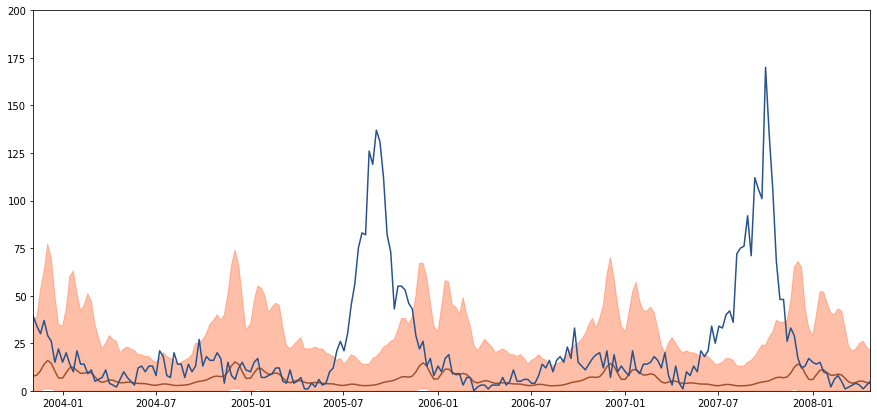

In [126]:
plt.plot(forecast.ds, forecast.yhat, color='sienna')
plt.fill_between(forecast.ds, forecast.yhat_lower, forecast.yhat_upper, edgecolor='coral', facecolor='coral', alpha=0.5)
plt.plot(sj_train.index, sj_train.total_cases, color='#26538D')
plt.xlim(sj_train_test.index[0], sj_train_test.index[-1]);
plt.ylim(0,200);

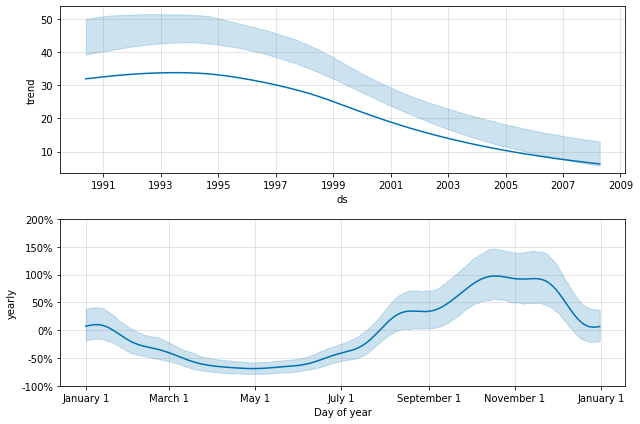

In [106]:
m.plot_components(forecast.drop('cap', axis=1));

## Iquitos

In [108]:
prophet_df = pd.DataFrame(iq_train_train.dropna().total_cases).reset_index()
prophet_df.columns = ['ds', 'y']
# prophet_df = pd.concat([prophet_df, iq_train_train.dropna()[my_exogs_2].reset_index()], axis=1)
prophet_df['cap'] = 3 * prophet_df['y'].max()
prophet_df

,ds,y,cap
0,2002-01-01,4,348
1,2002-01-08,11,348
2,2002-01-15,16,348
3,2002-01-22,23,348
4,2002-01-29,12,348
...,...,...,...
327,2008-04-15,1,348
328,2008-04-22,3,348
329,2008-04-29,1,348
330,2008-05-06,1,348


In [112]:
m = Prophet(interval_width=0.95,
            mcmc_samples=1000,
            growth='logistic',
            yearly_seasonality=True, 
            seasonality_mode='multiplicative', 
            likelihood='NegBinomial')

Here, a good selection of external variables should be important.

In [113]:
# m.add_regressor('station_min_temp_c_L2')
# m.add_regressor('reanalysis_dew_point_temp_k_L2')

In [114]:
model = m.fit(prophet_df)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_lpmf: Location parameter[11] is 0, but must be > 0!  (in 'unknown file name' at line 145)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_lpmf: Location parameter[11] is 0, but must be > 0!  (in 'unknown file name' at line 145)

If this warning occurs sporadically, such as for highly constrained variable types like covariance ma


Gradient evaluation took 0.000485 seconds
1000 transitions using 10 leapfrog steps per transition would take 4.85 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000665 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.65 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000735 seconds
1000 transitions using 10 leapfrog steps per transition would take 7.35 seconds.
Adjust your expectations accordingly!



Gradient evaluation took 0.000662 seconds
1000 transitions using 10 leapfrog steps per transition would take 6.62 seconds.
Adjust your expectations accordingly!


Iteration:   1 / 1000 [  0%]  (Warmup)
Iteration:   1 / 1000 [  0%]  (Warmup)
Iteration:   1 / 1000 [  0%]  (Warmup)
Iteration:   1 / 1000 [  0%]  (Warmup)


Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_lpmf: Location parameter[11] is 0, but must be > 0!  (in 'unknown file name' at line 145)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_lpmf: Location parameter[21] is 0, but must be > 0!  (in 'unknown file name' at line 145)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is abou

Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 100 / 1000 [ 10%]  (Warmup)
Iteration: 200 / 1000 [ 20%]  (Warmup)
Iteration: 200 / 1000 [ 20%]  (Warmup)
Iteration: 200 / 1000 [ 20%]  (Warmup)
Iteration: 200 / 1000 [ 20%]  (Warmup)
Iteration: 300 / 1000 [ 30%]  (Warmup)
Iteration: 300 / 1000 [ 30%]  (Warmup)
Iteration: 300 / 1000 [ 30%]  (Warmup)
Iteration: 300 / 1000 [ 30%]  (Warmup)
Iteration: 400 / 1000 [ 40%]  (Warmup)
Iteration: 400 / 1000 [ 40%]  (Warmup)
Iteration: 400 / 1000 [ 40%]  (Warmup)
Iteration: 400 / 1000 [ 40%]  (Warmup)
Iteration: 500 / 1000 [ 50%]  (Warmup)
Iteration: 501 / 1000 [ 50%]  (Sampling)
Iteration: 500 / 1000 [ 50%]  (Warmup)
Iteration: 501 / 1000 [ 50%]  (Sampling)
Iteration: 500 / 1000 [ 50%]  (Warmup)
Iteration: 501 / 1000 [ 50%]  (Sampling)
Iteration: 500 / 1000 [ 50%]  (Warmup)
Iteration: 501 / 1000 [ 50%]  (Sampling)
Iteration: 600 / 1000 [ 60%]  (Sampling)
Iteration: 600 

In [115]:
iq_train_test.shape

(110, 23)

In [116]:
future = m.make_future_dataframe(periods=110,freq='W')
# future

Adding the external information to the `future` dataframe, this is analog to adding, say, holidays or weather forecasts.

In [117]:
# future = pd.concat([future, sj_train.dropna()[['station_min_temp_c_L2', 'reanalysis_dew_point_temp_k_L2']].reset_index()], axis=1)
# future = future.drop('week_start_date', axis=1)
future['cap'] = 3 * prophet_df['y'].max()
future

,ds,cap
0,2002-01-01,348
1,2002-01-08,348
2,2002-01-15,348
3,2002-01-22,348
4,2002-01-29,348
...,...,...
437,2010-05-23,348
438,2010-05-30,348
439,2010-06-06,348
440,2010-06-13,348


In [118]:
forecast = m.predict(future)
forecast.tail()

,ds,trend,cap,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
437,2010-05-23,5.481775,348,0.0,19.0,5.577522,11.183840,-0.368936,-0.630672,-0.031700,-0.368936,-0.630672,-0.031700,0.0,0.0,0.0,3.516700
438,2010-05-30,5.480027,348,0.0,18.0,5.564931,11.201525,-0.395908,-0.652139,-0.064892,-0.395908,-0.652139,-0.064892,0.0,0.0,0.0,3.375429
439,2010-06-06,5.478280,348,0.0,19.0,5.552440,11.219238,-0.397043,-0.643584,-0.079301,-0.397043,-0.643584,-0.079301,0.0,0.0,0.0,3.368552
440,2010-06-13,5.476534,348,0.0,17.0,5.540049,11.240885,-0.426765,-0.643487,-0.147292,-0.426765,-0.643487,-0.147292,0.0,0.0,0.0,3.214331
441,2010-06-20,5.474788,348,0.0,15.0,5.527686,11.261520,-0.498721,-0.730616,-0.204759,-0.498721,-0.730616,-0.204759,0.0,0.0,0.0,2.848473


This `clips` the possible values, so that there are no negative values (we have count values as the target!!!)

In [119]:
for col in ['yhat', 'yhat_lower', 'yhat_upper']:
    forecast[col] = forecast[col].clip(lower=0.0)

In [120]:
# m.plot(forecast.drop('cap', axis=1), include_legend=False);
# Doesn't work because function is not up to date with the main package

In [131]:
pred = pd.DataFrame(forecast[['yhat', 'ds']])
pred.index = pred.ds
pred = pred.drop('ds', axis=1)
pred = pred.loc[iq_train_test.index[0]:]

In [132]:
iq_train_test.total_cases.iloc[:-1]

2008-05-20    2
2008-05-27    1
2008-06-03    1
2008-06-10    0
2008-06-17    0
             ..
2010-05-21    6
2010-05-28    5
2010-06-04    8
2010-06-11    1
2010-06-18    1
Name: total_cases, Length: 109, dtype: int64

In [133]:
pd.Series(pred.yhat)

ds
2008-05-25    3.548145
2008-06-01    3.477189
2008-06-08    3.447599
2008-06-15    3.192916
2008-06-22    2.799512
                ...   
2010-05-23    3.516700
2010-05-30    3.375429
2010-06-06    3.368552
2010-06-13    3.214331
2010-06-20    2.848473
Name: yhat, Length: 109, dtype: float64

In [134]:
model_classification(iq_train_test.total_cases.iloc[:-1], pd.Series(pred.yhat))

--------------------
RMSE: 11.29
--------------------
MAE: 6.36
Explained variance: 0.105
--------------------


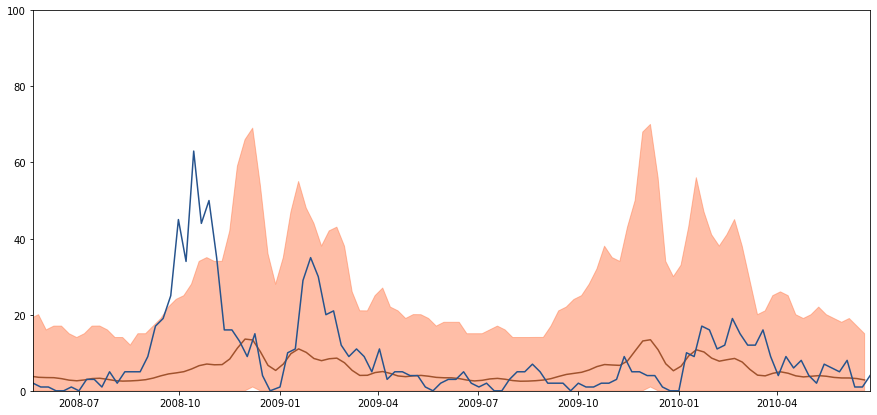

In [127]:
plt.plot(forecast.ds, forecast.yhat, color='sienna')
plt.fill_between(forecast.ds, forecast.yhat_lower, forecast.yhat_upper, edgecolor='coral', facecolor='coral', alpha=0.5)
plt.plot(iq_train.index, iq_train.total_cases, color='#26538D')
plt.xlim(iq_train_test.index[0], iq_train_test.index[-1]);
plt.ylim(0,100);

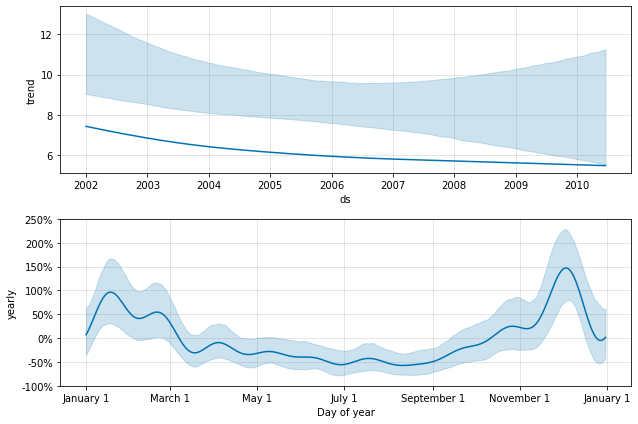

In [125]:
m.plot_components(forecast.drop('cap', axis=1));